# Fine-grained sentiment analysis of Yelp restaurant reviews with pytorch

The dataset used in this project has been provided by yelp (https://www.yelp.com/dataset) and consists of close to 7 million reviews on different types of businesses in several different metropolitan areas in USA and Canada. The dataset is split into 5 different files: business information, reviews, tips, users and check-in data. The business information consists of information about the different businesses such as name, postal code, location, rating, business category and number of reviews. The review data is where we find all the reviews and ratings for all the different businesses as well as unique user ids. We are aware that not every review might be insightful and we will make a filtering effort at a later stage. The user file consists of information about each of the individual users such as the average rating they give and reactions they have received both on their own reviews and given to others. The check-in data provides timestamps for check-ins made at each individual business while the tip data consists of data similar to the reviews but in a condensed way. Both are not being used in the course of this project.


**NOTE: The first part of this notebook is purely data exploration and pre-processing. **

## Imports and settings

In [7]:
!pip install transformers
!pip install stopwords
!pip install cleantext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
from sklearn.decomposition import LatentDirichletAllocation
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from stopwords import get_stopwords
from sklearn.metrics import f1_score, accuracy_score
from sklearn.feature_extraction import _stop_words
import string
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
Stop_Words= _stop_words.ENGLISH_STOP_WORDS
from cleantext import clean 
import seaborn as sns
from wordcloud import WordCloud
import datetime as dt
from time import time
import transformers
from transformers import BertModel, BertTokenizer, AdamW,get_linear_schedule_with_warmup
import nltk
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from collections import defaultdict

from torch import nn, optim
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [9]:
#download these packages once, if not already done
#nltk.download('vader_lexicon')
#nltk.download('wordnet')
#nltk.download('punkt')
#nltk.download('omw-1.4')

In [10]:
FIG_SIZE = (8, 5)
sns.set_style("whitegrid")
sns.set(rc = {'figure.figsize': FIG_SIZE})
matplotlib.rcParams['figure.figsize'] = FIG_SIZE
plt.rcParams['figure.figsize'] = FIG_SIZE

## Importing data

In [11]:
#Import the dataset
df = pd.read_csv(r'clean_df_small.csv')

In [12]:
df.head()

,Unnamed: 0,review_id,user_id,business_id,stars_review,useful_review,funny_review,cool_review,text,date,...,name_business,city,state,postal_code,stars_business,review_count_business,attributes,categories,year,text_clean
0,9211,8eqUW6mnZ0FYcjpL_6VF7w,Hi10sGSZNxQH3NLyWSZ1oA,yE6aDcbbK8pmvNroXnQYQA,4,20,13,19,Now that corona is on us\nAnd we hope the extr...,2020-07-19 23:18:10,...,Majoria's Commerce Restaurant,New Orleans,LA,70130,4.5,866,"{'RestaurantsAttire': ""u'casual'"", 'Restaurant...","Diners, Sandwiches, Restaurants, Breakfast & B...",2020,now corona us hope extreme right wont bomb us ...
1,6342,VY6AdwdPnfwhZ8BwMokH1w,hWDybu_KvYLSdEFzGrniTw,ku8cAVBLaF_4rI-yK6gNnQ,5,18,10,16,Five stars for the lovely Brittney who made ou...,2020-10-19 15:02:09,...,Brennan's,New Orleans,LA,70130,4.0,1598,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Cajun/Creole, Restaurants",2020,five stars lovely brittney made bananas foster...
2,6451,zpDo1qrEYC6G8YlK1vUaDg,hWDybu_KvYLSdEFzGrniTw,iSRTaT9WngzB8JJ2YKJUig,5,22,13,19,I usually write my reviews in the order I visi...,2020-10-19 13:33:05,...,Mother's Restaurant,New Orleans,LA,70130,3.5,5185,"{'RestaurantsGoodForGroups': 'True', 'BYOBCork...","Cajun/Creole, Restaurants, Event Planning & Se...",2020,usually write reviews order visit business som...
3,5059,C4Sv_LbycqWNwWH4iWUdwg,Hm0diOkWwpo9zotlJlqMUQ,H41S-qS3NOUJSbIqWTuyIA,4,61,27,53,This cruise is pure New Orleans!\n\nWe used ou...,2020-03-08 19:17:44,...,Paddlewheeler Creole Queen,New Orleans,LA,70130,4.0,713,"{'WiFi': ""'no'"", 'GoodForKids': 'True', 'Resta...","Hotels & Travel, Cajun/Creole, Boat Charters, ...",2020,cruise pure new orleans used city pass ride ab...
4,1305,dM-QT9s9mfqlXJCOI9LJlw,Hm0diOkWwpo9zotlJlqMUQ,I6L0Zxi5Ww0zEWSAVgngeQ,4,56,25,54,It's beignet a while... Nice outdoor-style caf...,2020-03-12 01:42:05,...,Cafe Beignet on Bourbon Street,New Orleans,LA,70130,3.5,1066,"{'GoodForKids': 'True', 'OutdoorSeating': 'Tru...","Sandwiches, Breakfast & Brunch, Cajun/Creole, ...",2020,beignet nice outdoorstyle cafe amazing beignet...


Text(0, 0.5, 'Number of reviews')

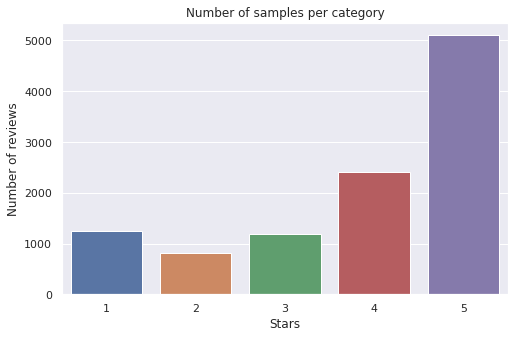

In [13]:
plt = sns.barplot(x=df.stars_review.value_counts().index, y=df.stars_review.value_counts())
plt.tick_params(axis='x')
plt.set_title("Number of samples per category")
plt.set_xlabel('Stars')
plt.set_ylabel('Number of reviews')

After testing balanced classes, we have seen that the model works best with more data even though it is unbalanced thowards the label 5.

In [14]:
# Map stars from 0-4 to remove errors
df['stars_review'] = df['stars_review'].apply(lambda x: x-1)

### Data processing

In [15]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

sample_txt = 'Super tasty pizzas and unbeatable quality-price for Denmark, very friendly staff, I would repeat without hesitation!'

tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print("Review: "+sample_txt+'\n')
print(" Tokens: "+str(tokens))
print(" Token IDS: "+str(token_ids))

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Review: Super tasty pizzas and unbeatable quality-price for Denmark, very friendly staff, I would repeat without hesitation!

 Tokens: ['Super', 'ta', '##sty', 'pizza', '##s', 'and', 'un', '##beat', '##able', 'quality', '-', 'price', 'for', 'Denmark', ',', 'very', 'friendly', 'staff', ',', 'I', 'would', 'repeat', 'without', 'hesitation', '!']
 Token IDS: [3198, 27629, 13913, 13473, 1116, 1105, 8362, 14262, 1895, 3068, 118, 3945, 1111, 5140, 117, 1304, 4931, 2546, 117, 146, 1156, 9488, 1443, 13941, 106]


In [16]:
BATCH_SIZE = 16
MAX_LEN = 140

train, test = train_test_split(df, test_size=0.2)
val, test = train_test_split(test, test_size=0.5)

print("Train: {}, Test: {} Val: {}".format(train.shape, test.shape, val.shape))

Train: (8586, 26), Test: (1074, 26) Val: (1073, 26)


In [17]:
if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("GPU")
else:
  device = torch.device("cpu")
  print("CPU")

GPU


In [18]:
class GenDataset(Dataset):

  def __init__(self, text, stars_review):
    self.text = text
    self.stars_review = stars_review
    self.tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
    self.max_len = MAX_LEN
  
  def __len__(self):
    return len(self.text)
  
  def __getitem__(self, item):
    text = str(self.text[item])
    star = self.stars_review[item]

    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'stars_review': torch.tensor(star, dtype=torch.long)
    }


In [19]:
def create_data_loader(df):
  ds = GenDataset(
    text=df.text.to_numpy(),
    stars_review=df.stars_review.to_numpy()
  )

  return DataLoader(
    ds,
    batch_size=BATCH_SIZE
  )

In [20]:
train_data_loader = create_data_loader(train)
test_data_loader = create_data_loader(test)
val_data_loader = create_data_loader(val)

In [21]:
data = next(iter(train_data_loader))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


### 2.1.1 - Fine-Grained Sentiment Classifier

In [22]:
bert_model = BertModel.from_pretrained('bert-base-cased',return_dict=False)

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [23]:
class FineGrainedSentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(FineGrainedSentClassifier, self).__init__()
    self.bert = bert_model
    self.drop = nn.Dropout(p=0.25)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

classes = sorted(train.stars_review.unique())


model = FineGrainedSentClassifier(len(classes)).to(device)

input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

In [24]:
def train_epoch(model, data_loader, loss_fn, optimizer, length):

  correct_predictions = 0
  p_loss = []

  model = model.train()

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    stars_review = d["stars_review"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, stars_review)

    correct_predictions += torch.sum(preds == stars_review)
    p_loss.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    optimizer.zero_grad()

  return correct_predictions.double() / length, np.mean(p_loss)

In [25]:
def eval_model(model, data_loader, loss_fn, length):
  
  correct_predictions = 0
  p_loss = []

  model = model.eval()

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      stars_review = d["stars_review"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, stars_review)
      
      correct_predictions += torch.sum(preds == stars_review)
      p_loss.append(loss.item())

  return correct_predictions.double() / length, np.mean(p_loss)


In [26]:
EPOCHS = 3

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=len(train_data_loader) * EPOCHS
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [27]:
%%time

history = defaultdict(list)
best_acc = 0

for count, epoch in enumerate(range(EPOCHS)):

  print('Epoch number:  '+str(count+1))
  print('----------------------------')

  train_acc, train_loss = train_epoch(model,train_data_loader,loss_fn, optimizer,len(train))

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(model,val_data_loader,loss_fn, len(val))

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc >= best_acc:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_acc = val_acc

Epoch number:  1
----------------------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Train loss 0.977420560585498 accuracy 0.5867691590962031
Val   loss 0.7962217966423315 accuracy 0.6728797763280522

Epoch number:  2
----------------------------
Train loss 0.7300777918133656 accuracy 0.6974143955276031
Val   loss 0.8154163081198931 accuracy 0.6672879776328052

Epoch number:  3
----------------------------
Train loss 0.5467254828446626 accuracy 0.789308176100629
Val   loss 0.9241628107779166 accuracy 0.6700838769804287

CPU times: user 8min 36s, sys: 3min 18s, total: 11min 54s
Wall time: 12min 4s


Discussion about the model: 

Since the dataset that we are using is unbalanced towards the category 5, it is likely to overfit towards this class. We can see that when the train loss decreases and accuracy improves while the validation loss increases and the accuracy does not improve sustancially.

To prevent that there are two main approaches we could follow:

* Balance the data and go for larger epoch training since we will most likely not be overfitting and will learn how to generalise for the average.

* To train it with all the data eventhough is unbalanced but reduce the training (less epoch)

After testing different scenarios we have seen that the case that works best is to use all the data available and train the model less to prevent overfitting. 

### Evaluation matrix

In [28]:
test_acc, _ = eval_model(model,test_data_loader,loss_fn,len(test))

print('Accuracy: '+str(test_acc.item()))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Accuracy: 0.664804469273743


In [29]:
def get_predictions(model):
  model = model.eval()
  
  review_texts = []
  predictions = []
  real_values = []
  prediction_probs = []

  with torch.no_grad():
    for d in test_data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      stars_review = d["stars_review"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts+=texts
      predictions+=preds
      real_values+=stars_review
      prediction_probs+=probs

  return review_texts, torch.stack(predictions).cpu(), torch.stack(real_values).cpu(), torch.stack(prediction_probs).cpu()

In [30]:
y_review_texts, y_pred, y_test, y_pred_probs = get_predictions(model)

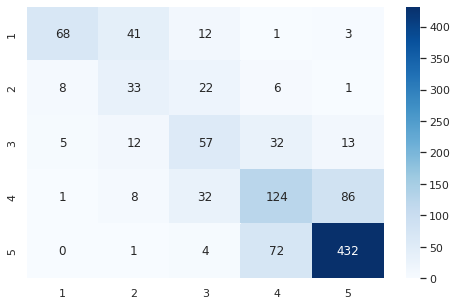

In [35]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=[1,2,3,4,5], columns=[1,2,3,4,5])
sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")